In [1]:
!pip install --upgrade -q "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 4.7 MB/s eta 0:00:00


In [2]:
!pip install -q git+https://github.com/google/flax

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


In [3]:
!pip install --upgrade -q jaxlib clu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 KB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import jax
import jax.numpy as jnp

from flax import linen as nn
import optax
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
# This finction loads the MNIST dataset into memory

def get_datasets(num_epochs, batch_size):
  train_ds = tfds.load('mnist', split='train') # 60,000 images (28x28)
  test_ds = tfds.load('mnist', split='test') # 10,000 images (28x28)
  
  # Let's cast the pixel values into floats and normalize them
  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                          'label': sample['label']})
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'], tf.float32) / 255.,
                                        'label': sample['label']})

  train_ds = train_ds.repeat(num_epochs).shuffle(10*batch_size) # allocating a buffer to randomly draw elements from
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
  test_ds = test_ds.shuffle(10*batch_size) # allocating a buffer to randomly draw elements from
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return train_ds, test_ds

In [6]:
# Setting up a template; the parameters (kernels, biases, etc.) are a separate object
class CNN(nn.Module):
    
  # __call__ subsumes __init__  
  @nn.compact
  def __call__(self, x):
    # Shape is (1, 28, 28, 1)
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    # Shape is (1, 28, 28, 32)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    # Shape is (1, 14, 14, 32)
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    # Shape is (1, 14, 14, 64)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    # Shape is (1, 7, 7, 64)
    x = x.reshape((x.shape[0], -1))  # flatten but keep batch dimension
    # Shape is (1, 3136 = 7x7x64)
    x = nn.Dense(features=256)(x)
    # Shape is (1, 256)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    # Shape is (1, 10)
    return x

In [7]:
# To create a summary for the Module instantiate with template data
print(CNN().tabulate(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1))))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,… │ float32[1,10]     │ Conv_0:           │
│         │        │                   │                   │   bias:           │
│         │        │                   │                   │ float32[32]       │
│         │        │                   │                   │   kernel:         │
│         │        │                   │                   │ float32[3,3,1,32] │
│         │        │                   │                   │ Conv_1:           │
│         │        │                   │                   │   bias:           │
│         │        │                   │                   │ float32[64]       │
│         │        │       

Let's create a single dataclass that represents the entire training state, including step number, parameters, and optimizer state. This class will subclass flax.training.train_state.TrainState 

The clu library contains utils for common ML training loops. Here we will use it for evaluation metrics.

In [8]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses which could be safely processed with JAX 

In [9]:
# A set of metrics in a safe dataclass
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [10]:
class TrainState(train_state.TrainState):
  # Our train state will have metrics attribute
  metrics: Metrics

In [11]:
# This function will intialize our training state
def create_train_state(module, rng, learning_rate, momentum):
  # initialize parameters by passing a template image
  params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  # Stochastic gradient descent optimizer
  tx = optax.sgd(learning_rate, momentum)
  # Th Module foward pass will be in the TrainState apply function. 
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

The training step takes the following actions on a batch:
    
    1. Takes a forward pass with the current state parameters.
    2. Evaluates cross entropy loss.
    3. Evaluates the gradient of the loss function with jax.grad
    4. Applies a pytree of gradients to update the model parameters.
    
We trace the entire train_step function and just-in-time compile it with XLA.

In [12]:
@jax.jit
def train_step(state, batch):
  #Below the loss function will be evaluated with the current state parameters
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image']) #Log(prob_i)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

We want to compute metrics during validation and testing, so their computation will be in a separate function. The lone * indicates that all following arguments are keyword-only arguments, that is, they can only be provided using their name, not as positional argument.

In [13]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [14]:
# Let's assure tfds shuffles are reproducible
tf.random.set_seed(42)

# We also need JAX PRNGKey for the parameter initialization
init_rng = jax.random.PRNGKey(43)

In [15]:
num_epochs = 10
batch_size = 32

# Download, shuffle, batch the data with the function we defined
train_ds, test_ds = get_datasets(num_epochs, batch_size)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
len(train_ds), len(test_ds)
# (60000/32*10, 10000/32)

(18750, 312)

In [17]:
# The optimizer parameters
learning_rate = 0.003
momentum = 0.9

In [18]:
state = create_train_state(CNN(), init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [19]:
# since train_ds is replicated num_epochs times in get_datasets(), we divide by num_epochs
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

In [20]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

Finally we are ready to run training

In [22]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.3164169490337372, accuracy: 90.77333068847656
test epoch: 1, loss: 0.1178973913192749, accuracy: 96.40425109863281
train epoch: 2, loss: 0.09999601542949677, accuracy: 97.05999755859375
test epoch: 2, loss: 0.08152561634778976, accuracy: 97.39583587646484
train epoch: 3, loss: 0.06964550167322159, accuracy: 97.93000030517578
test epoch: 3, loss: 0.07509435713291168, accuracy: 97.53605651855469
train epoch: 4, loss: 0.054094765335321426, accuracy: 98.37166595458984
test epoch: 4, loss: 0.0652463436126709, accuracy: 97.76642608642578
train epoch: 5, loss: 0.04475114867091179, accuracy: 98.64833068847656
test epoch: 5, loss: 0.051112230867147446, accuracy: 98.32732391357422
train epoch: 6, loss: 0.03706596419215202, accuracy: 98.91166687011719
test epoch: 6, loss: 0.05622227489948273, accuracy: 98.09695434570312
train epoch: 7, loss: 0.03183569759130478, accuracy: 99.0999984741211
test epoch: 7, loss: 0.058440085500478745, accuracy: 98.09695434570312
train epoch: 8

Let's visualize the metrics during training

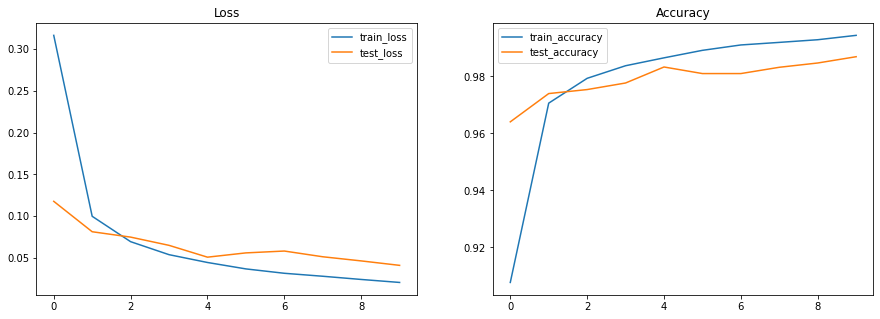

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

And we can do inference on a test set.

In [24]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, test_batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

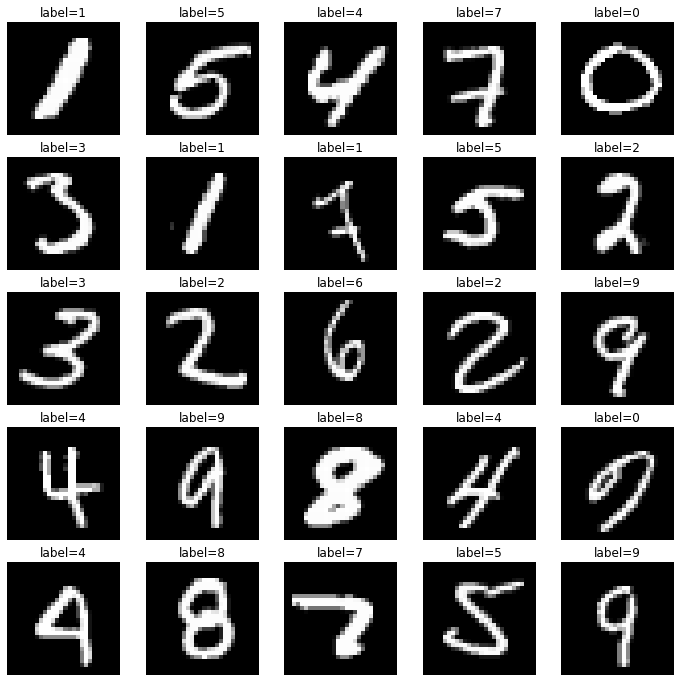

In [25]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')

Homework: Play with the layers of the Model, the activation function and the hyperparameters to achieve Test accuracy over 99.5%

Push your code to GitHub on branch carrying your name.